In [2]:
import pandas as pd
import openpyxl
import xlrd
import numpy as np
from numpy import nan
import glob
import datetime
from math import cos, sin, pi 

##required for plots: 
##in order to perform the visualization tasks:
import matplotlib.pyplot  as plt

In [4]:

## we want no cientific notation numbers:
np.set_printoptions(suppress=True)

In [5]:

def df_monthly_total_production(list_directories):
    
    ##Here we define all our empty arrays determined to be our future features:
    seasonability_1 = np.empty(0)
    seasonability_2 = np.empty(0)
    
    pmf = np.empty(0)
    empty_array = np.empty(0)
    
    trend = np.empty(0)

    number_months = range(1,13)
    
    for year in list_directories:
        for data in year:
                ## we open each year and then each excel related to each month:
                df = pd.read_excel(data, engine='openpyxl')
                fm = empty_array
                
                ## we filter only the bill lines which are commercial invices (values 'F' of the 'TipoDoc' Column):
                df = df.loc[df['TipoDoc'].isin(['F'])]
                
                ## we filter the date info inside the fecha column:
                df['year'] = pd.DatetimeIndex(df['Fecha']).year
                df['month'] = pd.DatetimeIndex(df['Fecha']).month
                
                ## in order to know when a line is part of the same bill we stablished that the value for a row
                ## in the column 'Linea Doc' it has to be different in the next row when they share the same value in 
                ## the column 'Documento' (ID number of the document), that's why we use the pandas command shift:
                df['siguiente_linea'] = df['LineaDoc'].shift(-1)
                df['siguiente_doc'] = df['Documento'].shift(-1)

                ## now in the last row we will have a NaN value, we should change that:
                
                ## let's try to use the pandas' command .drop() in order to implement the mentioned restriction:
                df = df.drop(df[(df['Documento'] == df['siguiente_doc']) & (df['LineaDoc'] == df['siguiente_linea'])].index)
                
                ## we sum up the value of the left rows (commercial invoices), which is the value related to the column 'Importe':
                fm = df['Importe'].sum()
                
                ## we append to the general array the result of the fourth weeks of the loaded month:
                pmf = np.append(pmf, fm)

        ## we store the trend info (passage of time):
        ## we store the year:
        for month in number_months:
            y = df['year'][-1:]
            trd = y + (month - 1)/12

            ## then we store this trend number into an array:
            trend = np.append(trend, trd)
            
            ## we save the information of the month:
            dt_circ_base = (month/12)*2*pi # entre 0 y 2*pi
            features_dt_circ = [cos(dt_circ_base), sin(dt_circ_base)] # 2 valores, a rellenar en 2 columnas de features
            
            ## we store the info of the cos:
            seasonability_1 = np.append(seasonability_1, features_dt_circ[0])

            ## and the info  of the sin:
            seasonability_2 = np.append(seasonability_2, features_dt_circ[1])
                      
    ##here after the iterations are done we store the arrays generated:
    yTrain = pd.DataFrame({'target':pmf})
    
    xTrain = pd.DataFrame({'seasonability_circ_cos':seasonability_1,'seasonability_circ_sin':seasonability_2, 'time':trend, 'y_t-1':yTrain.target.shift(1)})
    return yTrain, xTrain


In [7]:
tablas20_1 = glob.glob("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/raw/2015_*.xlsx")
tablas20_2 = glob.glob("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/raw/2016_*.xlsx")
tablas20_3 = glob.glob("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/raw/2017_*.xlsx")
tablas20_4 = glob.glob("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/raw/2018_*.xlsx")
tablas20_5 = glob.glob("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/raw/2019_*.xlsx")
tablas20_all = list([tablas20_1,tablas20_2,tablas20_3, tablas20_4, tablas20_5])

In [8]:
y, x = df_monthly_total_production(tablas20_all)

In [20]:
y.target[0:12].sum()

98955203.71999998

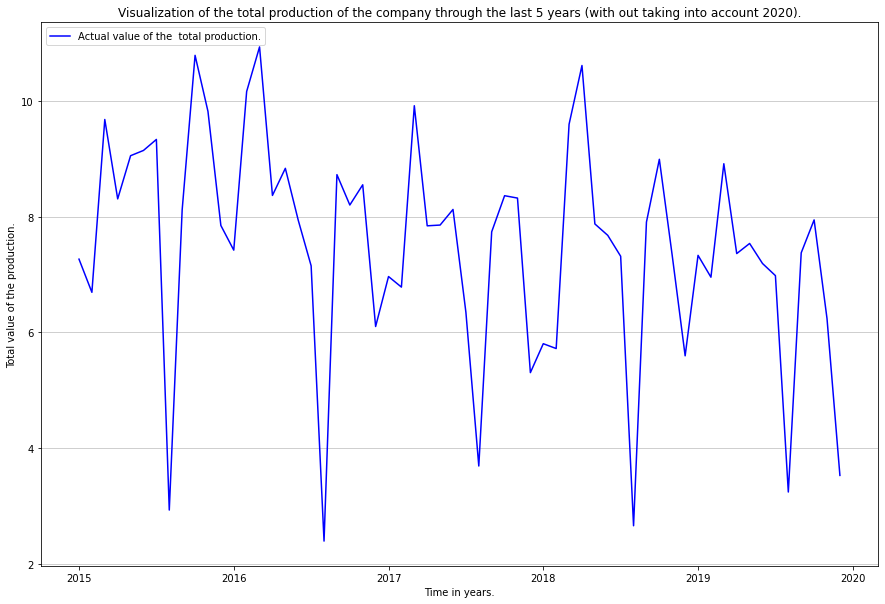

In [12]:
t = x.time
y_time_serie = y.target/10e5
from pylab import rcParams
ax = plt.figure(figsize=(15,10)).add_subplot(111)
ax.plot(t,y_time_serie,'-b', label = 'Actual value of the  total production.')
ax. legend(loc='upper left')
plt.title('Visualization of the total production of the company through the last 5 years (with out taking into account 2020).')
plt.xlabel('Time in years.')
plt.ylabel('Total value of the production.')

plt.grid(axis='y', alpha=0.75)

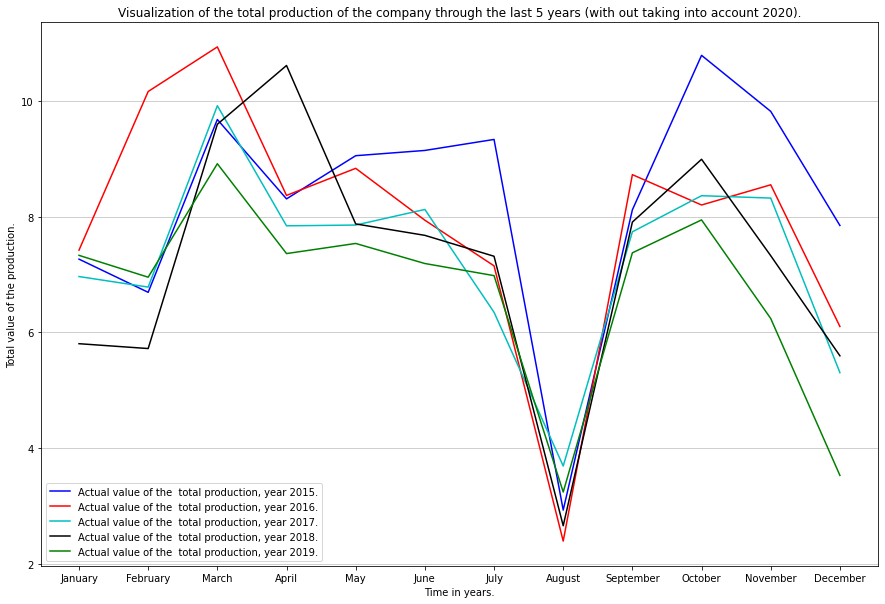

In [13]:
months = np.array(['January', 'February','March','April','May','June','July','August','September','October','November','December'])

## then we generate an array for each year
y_2015 = y_time_serie[0:12]
y_2016 = y_time_serie[12:24]
y_2017 = y_time_serie[24:36]
y_2018 = y_time_serie[36:48]
y_2019 = y_time_serie[48:60]


## now we want to see all years at the same time just to compare between them:
ax = plt.figure(figsize=(15,10)).add_subplot(111)
ax.plot(months,y_2015,'-b', label = 'Actual value of the  total production, year 2015.')
ax.plot(months,y_2016,'-r', label = 'Actual value of the  total production, year 2016.')
ax.plot(months,y_2017,'-c', label = 'Actual value of the  total production, year 2017.')
ax.plot(months,y_2018,'-k', label = 'Actual value of the  total production, year 2018.')
ax.plot(months,y_2019,'-g', label = 'Actual value of the  total production, year 2019.')

## we add legend and titles as well:
ax.legend(loc='lower left')
plt.title('Visualization of the total production of the company through the last 5 years (with out taking into account 2020).')
plt.xlabel('Time in years.')
plt.ylabel('Total value of the production.')

plt.grid(axis='y', alpha=0.75)

In [18]:
y.to_pickle("time_serie_y_total_production.pkl")

In [19]:
x.to_pickle("time_serie_x_total_production.pkl")